In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from kaggle_titanic_helpers import *
import missingno as msmn

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
# Getting spend cols
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

float_cols = list(train.dtypes[train.dtypes==float].index)
object_cols = list(train.dtypes[train.dtypes==object].index)

object_cols.remove('PassengerId')
object_cols.remove('Name')
object_cols.remove('Cabin')

In [4]:
# Doing basic fillna
train_df = fill_missing_basic(train,float_cols,object_cols,spend_cols)
test_df = fill_missing_basic(test,float_cols,object_cols,spend_cols)

In [5]:
# Adding a few different columns
train_df = basic_prep(train,spend_cols)
test_df = basic_prep(test,spend_cols)

In [6]:
# These people are not in the same cabin, but in same passenger group
# Need to look at capacity of cabin sizes
check_pass_group(train_df,'0138')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,deck,number,side,passenger_group,num_group,total_spend,total_spend_max,num_group_max,surname
127,0138_01,Earth,True,G/18/P,TRAPPIST-1e,13.0,False,0.0,0.0,0.0,...,1,G,18.0,P,0138,01,0.0,793.0,2,Gambs
128,0138_02,Earth,False,E/5/P,TRAPPIST-1e,34.0,False,0.0,22.0,0.0,...,0,E,5.0,P,0138,02,793.0,793.0,2,Gambs


In [19]:
train_df['deck'] = train_df['deck'].fillna(train_df['deck'].mode().values[0])
train_df['number'] = train_df['number'].fillna(train_df['number'].mode().values[0])
train_df['side'] = train_df['number'].fillna(train_df['number'].mode().values[0])

test_df['deck'] = test_df['deck'].fillna(test_df['deck'].mode().values[0])
test_df['number'] = test_df['number'].fillna(test_df['number'].mode().values[0])
test_df['side'] = test_df['number'].fillna(test_df['number'].mode().values[0])

In [8]:
# Our new features are missing values so basic fill
train_df.isna().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              199
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               200
Transported          0
deck                 0
number               0
side                 0
passenger_group      0
num_group            0
total_spend          0
total_spend_max      0
num_group_max        0
surname            200
dtype: int64

In [9]:
object_cols

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

In [10]:
float_cols

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

## Part 1: Creating standard model with no special filling

In [11]:
train_df_trans = feature_transformation(train_df,object_cols,float_cols)

train_df_trans.head()

,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,False,False,0,1,0,0,0,1,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000
1,False,False,1,0,0,0,0,1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823
2,False,True,0,1,0,0,0,1,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030
3,False,False,0,1,0,0,0,1,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997
4,False,False,1,0,0,0,0,1,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083


In [14]:
# Creating Train/Test splits

#Split in 75% train and 25% test set
X_train, X_val, y_train, y_val = train_test_split(train_df_trans,\
                                         train_df.Transported,test_size = 0.2)

In [16]:
import xgboost as xgb

clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pred = clf.predict(X_val)

# print accuracy
print("Accuracy: ", accuracy_score(y_val, pred))

# print precision, recall, F1-score per each class/tag
print(classification_report(y_val, pred))

# print confusion matrix, check documentation for sorting rows/columns
print(confusion_matrix(y_val, pred))

Accuracy:  0.78205865439908
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       871
           1       0.77      0.81      0.79       868

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

[[660 211]
 [168 700]]


In [18]:
# Re-train with all data
clf = xgb.XGBClassifier()

clf.fit(train_df_trans, train_df.Transported)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
test_df_trans = feature_transformation(test_df,object_cols,float_cols)

In [21]:
preds_class = clf.predict(test_df_trans)


pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('xgb_basic_submission.csv',index=False)

In [39]:
# xxb_basic_submission.csv
# Complete · Tyler Drumheller · 8m ago
# 0.77881

## Part 2: Making tweaks to fill process for features we know follow a pattern

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Adding a few different columns
train_df = basic_prep(train,spend_cols)
test_df = basic_prep(test,spend_cols)

In [24]:
train_df = fill_cryosleep(train_df)

train_df = fill_homeplanet(train_df)

0 Initially
0 After Step 1: Spending Money = No CryoSleep
0 After Step 2: 1 Passenger / Zero Spend = CryoSleep
0 After Step 3: Total Group Spend Zero = CryoSleep
0 After Step 4: Total Group Spend > Zero = No CryoSleep
201 Initially
111 after filling passenger groups
104 after filling Europa decks
63 after filling Earth decks
0 after filling the rest with Earth


In [25]:
test_df = fill_cryosleep(test_df)

test_df = fill_homeplanet(test_df)

93 Initially
38 After Step 1: Spending Money = No CryoSleep
23 After Step 2: 1 Passenger / Zero Spend = CryoSleep
16 After Step 3: Total Group Spend Zero = CryoSleep
0 After Step 4: Total Group Spend > Zero = No CryoSleep
87 Initially
46 after filling passenger groups
40 after filling Europa decks
31 after filling Earth decks
0 after filling the rest with Earth


In [26]:
# Doing basic fillna
train_df = fill_missing_basic(train,float_cols,object_cols,spend_cols)
test_df = fill_missing_basic(test,float_cols,object_cols,spend_cols)

In [27]:
train_df.isna().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              199
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               200
Transported          0
deck                 0
number             199
side               199
passenger_group      0
num_group            0
total_spend          0
dtype: int64

In [29]:
train_df['number'] = train_df['number'].fillna(train_df['number'].mode().values[0])
train_df['side'] = train_df['number'].fillna(train_df['number'].mode().values[0])

test_df['number'] = test_df['number'].fillna(test_df['number'].mode().values[0])
test_df['side'] = test_df['number'].fillna(test_df['number'].mode().values[0])

train_df.isna().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              199
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               200
Transported          0
deck                 0
number               0
side                 0
passenger_group      0
num_group            0
total_spend          0
dtype: int64

In [30]:
train_df_trans = feature_transformation(train_df,object_cols,float_cols)

train_df_trans.head()

,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,False,False,0,1,0,0,0,1,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000
1,False,False,1,0,0,0,0,1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823
2,False,True,0,1,0,0,0,1,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030
3,False,False,0,1,0,0,0,1,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997
4,False,False,1,0,0,0,0,1,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083


In [31]:
# Creating Train/Test splits

#Split in 75% train and 25% test set
X_train, X_val, y_train, y_val = train_test_split(train_df_trans,\
                                         train_df.Transported,test_size = 0.2)

In [32]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
# Slightly better output than basic fill
pred = clf.predict(X_val)

# print accuracy
print("Accuracy: ", accuracy_score(y_val, pred))

# print precision, recall, F1-score per each class/tag
print(classification_report(y_val, pred))

# print confusion matrix, check documentation for sorting rows/columns
print(confusion_matrix(y_val, pred))

Accuracy:  0.7826336975273146
              precision    recall  f1-score   support

       False       0.78      0.77      0.78       858
        True       0.78      0.79      0.79       881

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

[[664 194]
 [184 697]]


In [34]:
# Re-train with all data
clf = xgb.XGBClassifier()

clf.fit(train_df_trans, train_df.Transported)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
test_df_trans = feature_transformation(test_df,object_cols,float_cols)

In [36]:
preds_class = clf.predict(test_df_trans)

pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('xgb_cryo_planet_fill_submission.csv',index=False)

In [38]:
# xgb_cryo_planet_fill_submission.csv
# Complete · Tyler Drumheller · now
# 0.77881

## Testing with KNN Imputed Values

In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [42]:
# Adding a few different columns
train_df = basic_prep(train,spend_cols)
test_df = basic_prep(test,spend_cols)

In [45]:
train_df_trans = feature_transformation(train_df,object_cols,float_cols)

train_df_trans.head()

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,1,0,1,0,0,0,1,1,0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,0,1,0,0,0,1,1,0,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823
2,0,1,0,1,0,0,0,1,0,1,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030
3,0,1,0,1,0,0,0,1,1,0,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997
4,1,0,0,1,0,0,0,1,1,0,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083


In [46]:
train_df_trans.isna().sum()

HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
CryoSleep_False                0
CryoSleep_True                 0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
VIP_False                      0
VIP_True                       0
Age                          179
RoomService                  181
FoodCourt                    183
ShoppingMall                 208
Spa                          183
VRDeck                       188
dtype: int64

In [47]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
train_df_trans = pd.DataFrame(imputer.fit_transform(train_df_trans),columns = train_df_trans.columns)

In [48]:
train_df_trans.isna().sum()

HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
dtype: int64

In [49]:
# Creating Train/Test splits

#Split in 75% train and 25% test set
X_train, X_val, y_train, y_val = train_test_split(train_df_trans,\
                                         train_df.Transported,test_size = 0.2)

In [50]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [51]:
#  Best output so far, will use for further analysis
pred = clf.predict(X_val)

# print accuracy
print("Accuracy: ", accuracy_score(y_val, pred))

# print precision, recall, F1-score per each class/tag
print(classification_report(y_val, pred))

# print confusion matrix, check documentation for sorting rows/columns
print(confusion_matrix(y_val, pred))

Accuracy:  0.7901092581943646
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       874
           1       0.78      0.81      0.79       865

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

[[676 198]
 [167 698]]


In [52]:
# Re-train with all data
clf = xgb.XGBClassifier()

clf.fit(train_df_trans, train_df.Transported)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [53]:
test_df_trans = feature_transformation(test_df,object_cols,float_cols)

In [54]:
preds_class = clf.predict(test_df_trans)

pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('xgb_knn_fill_submission.csv',index=False)

In [ ]:
# xgb_knn_fill_submission.csv
# Complete · Tyler Drumheller · now
# 0.77928

## Part 4: GridSearch with KNN Imputted Dataset

In [84]:
clf = xgb.XGBClassifier()

parameters = {
     "eta"    : [0.01, 0.05, .075] ,
     "max_depth"        : [5, 8],
     "min_child_weight" : [1, 2, 5],
     "gamma"            : [.001, .005],
     "colsample_bytree" : [1, 2],
     "subsample"        : [.2, .5, .7] ,
#      "lambda"           : [.5, 1]
     "alpha"            : [0, .25, .5,],
     "n_estimators"     : [25, 50, 75]
#      "scoring" : ['accuracy','roc_auc']
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="accuracy",
                    cv=3,
                       verbose=3)

# No need to create test/train splits, as GridSearch will use CV to validate
grid.fit(train_df_trans, train_df.Transported)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=75, subsample=1;, score=0.792 total time=   0.6s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.790 total time=   0.3s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=1;, score=0.804 total time=   0.3s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.785 total time=   0.5s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=1;, score=0.787 total time=   0.5s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subs

[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=1;, score=0.804 total time=   0.6s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.7;, score=0.787 total time=   0.8s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=75, subsample=1;, score=0.792 total time=   0.7s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=0.789 total time=   0.3s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=1;, score=0.778 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=0.811 total time=   0.5s
[CV 1/3] END alpha=0.5

[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=0.786 total time=   0.3s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=1;, score=0.781 total time=   0.2s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=0.790 total time=   0.5s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=0.804 total time=   0.5s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.792 total time=   0.7s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.7;, score=0.791 total time=   0.7s
[CV 3/3] END alpha

[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=0.7;, score=0.793 total time=   0.6s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=1;, score=0.807 total time=   0.5s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=1;, score=0.804 total time=   0.2s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.7;, score=0.785 total time=   0.3s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=50, subsample=1;, score=0.786 total time=   0.3s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.811 total time=   0.5s
[CV 1/3] END alpha=0.5

[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.7;, score=0.807 total time=   0.5s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=1, n_estimators=25, subsample=0.5;, score=0.791 total time=   0.2s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.791 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=1, n_estimators=25, subsample=1;, score=0.807 total time=   0.2s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.794 total time=   0.4s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1;, score=0.790 total time=   0.4s
[CV 3/3] END alpha=0

[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=2, n_estimators=25, subsample=1;, score=0.807 total time=   0.2s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.7;, score=0.796 total time=   0.4s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=2, n_estimators=50, subsample=1;, score=0.788 total time=   0.4s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=2, n_estimators=75, subsample=0.5;, score=0.810 total time=   0.6s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=2, n_estimators=75, subsample=1;, score=0.797 total time=   0.6s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=25, subsample=0.5;, score=0.784 total time=   0.2s
[CV 3/3] END alpha=0.5

[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=25, subsample=0.7;, score=0.793 total time=   0.2s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=25, subsample=1;, score=0.792 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=50, subsample=0.5;, score=0.812 total time=   0.4s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=50, subsample=1;, score=0.793 total time=   0.4s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.795 total time=   0.6s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=7, min_child_weight=5, n_estimators=75, subsample=0.7;, score=0.794 total time=   0.6s
[CV 3/3] END alpha=0

[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.5;, score=0.796 total time=   0.7s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.7;, score=0.793 total time=   0.7s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=75, subsample=1;, score=0.807 total time=   0.7s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=1;, score=0.786 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=0.811 total time=   0.5s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=1;, score=0.789 total time=   0.5s
[CV 2/3] END alpha=0.5

[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.5;, score=0.802 total time=   0.2s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.2;, score=0.780 total time=   0.2s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.5;, score=0.806 total time=   0.3s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.2;, score=0.784 total time=   0.3s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.785 total time=   0.5s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.7;, score=0.786 total time=   0.4s
[CV 3/3] END alpha=0, colsam

[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.807 total time=   0.3s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.788 total time=   0.5s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.790 total time=   0.5s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.2;, score=0.812 total time=   0.4s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.7;, score=0.786 total time=   0.8s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.2;, score=0.813 total time=   0.2s
[CV 2/3] END alpha=0, colsam

[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=0.791 total time=   0.5s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=0.804 total time=   0.5s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.791 total time=   0.7s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.7;, score=0.791 total time=   0.8s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.785 total time=   0.2s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=0.809 total time=   0.2s
[CV 1/3] END alpha=0, colsam

[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=0.787 total time=   0.2s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.2;, score=0.811 total time=   0.3s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=0.793 total time=   0.5s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.2;, score=0.794 total time=   0.5s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.807 total time=   0.7s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.2;, score=0.786 total time=   0.1s
[CV 2/3] END alpha=0, colsa

[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=0.808 total time=   0.3s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=0.793 total time=   0.5s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=0.791 total time=   0.5s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.2;, score=0.808 total time=   0.5s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.7;, score=0.794 total time=   0.7s
[CV 1/3] END alpha=0, colsample

[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.788 total time=   0.3s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.791 total time=   0.3s
[CV 3/3] END alpha=0, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.2;, score=0.805 total time=   0.3s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.7;, score=0.788 total time=   0.4s
[CV 2/3] END alpha=0, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=2, n_estimators=25, subsample=0.2;, score=0.789 total time=   0.1s
[CV 1/3] END alpha=0, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=2, n_estimators=25, subsample=0.5;, score=0.788 total time=   0.2s
[CV 2/3] END alpha=0, 

[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2

[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2

[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2

[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2

[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_by

[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_by

[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0, colsample_by

[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.788 total time=   0.3s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.806 total time=   0.3s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.7;, score=0.774 total time=   0.3s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.7;, score=0.783 total time=   0.3s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.7;, score=0.803 total time=   0.3s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=0.2;, score=0.782 total time=   0.3s
[CV 2/3] E

[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=0.804 total time=   0.5s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.2;, score=0.784 total time=   0.4s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.2;, score=0.790 total time=   0.4s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.2;, score=0.808 total time=   0.4s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.790 total time=   0.8s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.5;, score=0.790 total time=   0.9s
[CV 3/3] E

[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.5;, score=0.786 total time=   0.2s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.5;, score=0.787 total time=   0.2s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.5;, score=0.810 total time=   0.2s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.785 total time=   0.2s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.790 total time=   0.3s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.807 total time=   0.3s
[CV 1/3] E

[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.2;, score=0.793 total time=   0.3s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.797 total time=   0.5s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.813 total time=   0.5s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.5;, score=0.796 total time=   0.7s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.7;, score=0.809 total time=   0.8s
[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.5;, score=0.811 total time=   0.3s
[CV 1/3] E

[CV 3/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.815 total time=   0.5s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.2;, score=0.792 total time=   0.5s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.5;, score=0.795 total time=   0.7s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.7;, score=0.793 total time=   0.8s
[CV 1/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.7;, score=0.789 total time=   0.3s
[CV 2/3] END alpha=0.25, colsample_bytree=1, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.2;, score=0.795 total time=   0.3s
[CV 2/3] E

[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.2

[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.2

[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.2

[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.2

[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.2

[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.2;, score=0.811 total time=   0.3s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=0.780 total time=   0.5s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=0.785 total time=   0.5s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=75, subsample=0.5;, score=0.807 total time=   0.5s
[CV 1/3] END alp

[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=0.783 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=0.810 total time=   0.2s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.777 total time=   0.4s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.788 total time=   0.7s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.806 total time=   0.4s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.01, gamma=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.773 total time=   0.6s
[CV 2/3] END alp

[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.25, colsample_bytree=2, eta=0.075, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alp

[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.7;, score=0.794 total time=   0.3s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=0.2;, score=0.810 total time=   0.3s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=0.7;, score=0.789 total time=   0.5s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.2;, score=0.785 total time=   0.1s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.5;, score=0.779 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.5;, score=0.809 total time=   0.2s
[CV 1/3] END alp

[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.2;, score=0.786 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.810 total time=   0.3s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=0.2;, score=0.785 total time=   0.3s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=0.5;, score=0.792 total time=   0.4s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=2, n_estimators=75, subsample=0.7;, score=0.812 total time=   0.5s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.7;, score=0.806 total time=   0.2s
[CV 1/3] END alp

[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.2;, score=0.810 total time=   0.2s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.5;, score=0.794 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=8, min_child_weight=1, n_estimators=25, subsample=0.7;, score=0.812 total time=   0.3s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.5;, score=0.798 total time=   0.5s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=8, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.794 total time=   0.5s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.05, gamma=0.001, max_depth=8, min_child_weight=1, n_estimators=75, subsample=0.2;, score=0.806 total time=   0.5s
[CV 1/3] END alp

[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.2;, score=0.797 total time=   0.4s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.807 total time=   0.6s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.2;, score=0.784 total time=   0.8s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.5;, score=0.793 total time=   1.0s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.7;, score=0.793 total time=   0.8s
[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=25, subsample=0.7;, score=0.790 total time=   0.3s
[CV 3/3] E

[CV 2/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=0.793 total time=   0.5s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.2;, score=0.806 total time=   0.5s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.001, max_depth=8, min_child_weight=5, n_estimators=75, subsample=0.7;, score=0.791 total time=   0.8s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.5;, score=0.785 total time=   0.2s
[CV 3/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=25, subsample=0.5;, score=0.812 total time=   0.2s
[CV 1/3] END alpha=0.5, colsample_bytree=1, eta=0.075, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=0.786 total time=   0.2s
[CV 2/3] E

[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.001, max_depth=8, min_child_weight=2, n_estimators=75, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, cols

[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, colsample_bytree=2, eta=0.01, gamma=0.005, max_depth=8, min_child_weight=5, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, cols

/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2916 fits failed out of a total of 5832.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2916 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = tr

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'alpha': [0, 0.25, 0.5], 'colsample_bytree': [1, 2],
                         'eta': [0.01, 0.05, 0.075], 'gamma': [0.001, 0.005],
                         'max_depth': [5, 8], 'min_child_weight': [1, 2, 5],
                         'n_estimators': [25, 50, 75],
                         'subsample': [0.2, 0.5, 0.7]},
             scoring='accuracy', verbose=3)

In [82]:
grid.best_score_

0.8034063303232308

In [85]:
grid.best_score_

0.8034063303232308

In [83]:
# Using best params to further re-train grid if best params are either extremes
grid.best_params_

{'alpha': 0.25,
 'colsample_bytree': 1,
 'eta': 0.05,
 'gamma': 0.005,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 0.5}

In [86]:
# Using best params to further re-train grid if best params are either extremes
grid.best_params_

{'alpha': 0.25,
 'colsample_bytree': 1,
 'eta': 0.05,
 'gamma': 0.005,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 0.5}

In [87]:
preds_class = grid.predict(test_df_trans)

pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('xgb_knn_fill_gs_submission.csv',index=False)

[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=25, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.001, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, cols

[CV 2/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.2;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 3/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.5;, score=nan total time=   0.0s
[CV 1/3] END alpha=0.5, colsample_bytree=2, eta=0.05, gamma=0.005, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3] END alpha=0.5, cols

In [ ]:
# xgb_knn_fill_gs_submission.csv
# Complete · Tyler Drumheller · now
# 0.78653

In [91]:
grid.best_estimator_

XGBClassifier(alpha=0.25, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, feature_types=None, gamma=0.005, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None, ...)

## Exploring Feature Importance

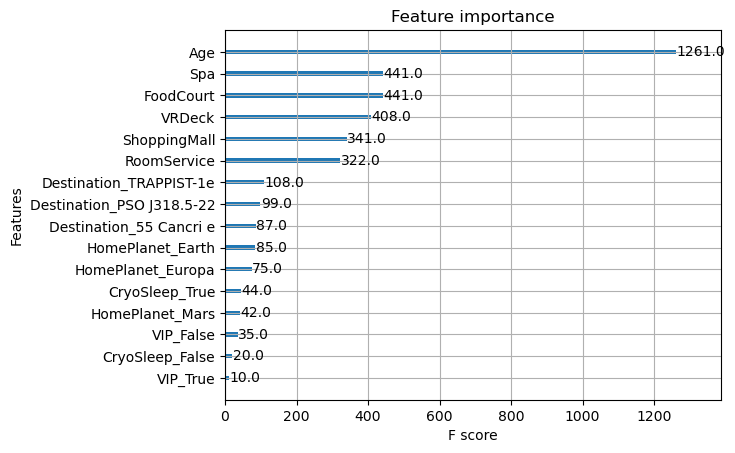

In [94]:
# plot feature importance...why are what I think are important so low?
from xgboost import plot_importance

plot_importance(grid.best_estimator_)
plt.show()